### Circuit Diagram: Qubit State After Creation

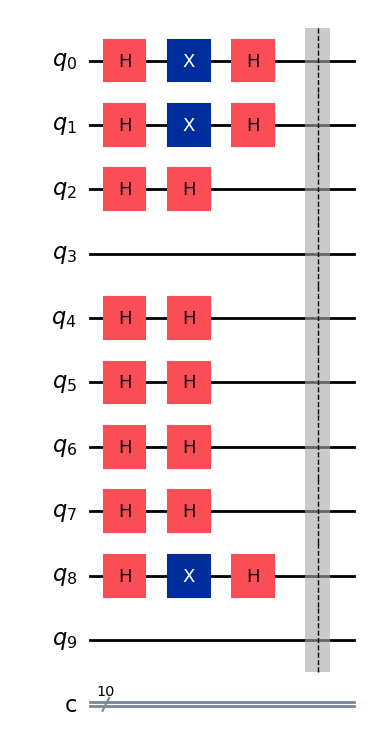

### Circuit Diagram: With Eavesdropping

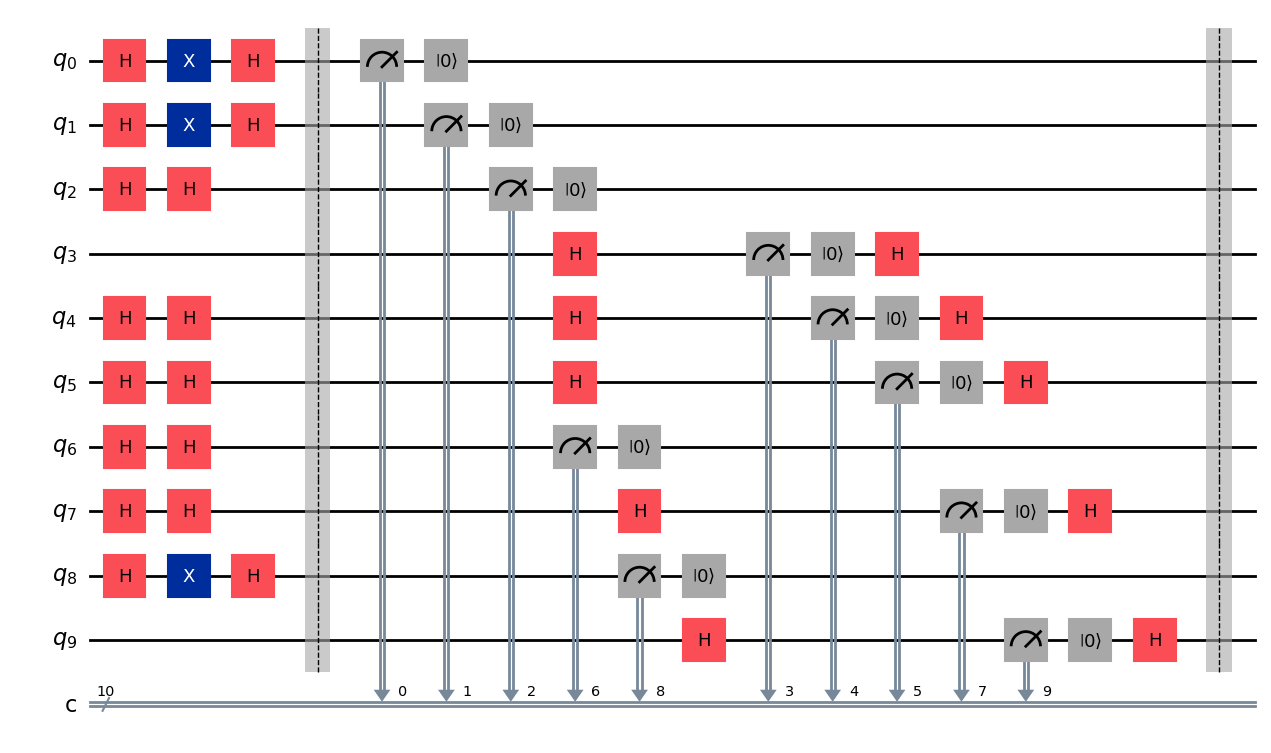

### Key Sifting Process

Sifted key: [0, 0, 0, 1]


### Conclusion

Eavesdropping detected: True


In [3]:
# Importing necessary modules from Qiskit for building and visualizing quantum circuits.
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from IPython.display import display, Markdown

# Initialize the simulator from Qiskit Aer, which allows for quantum circuit simulation.
simulator = AerSimulator()

# Define a function to create a quantum circuit based on the BB84 protocol.
def create_bb84_circuit(bits, bases):
    """
    Creates a quantum circuit for the BB84 protocol. Each qubit is prepared
    based on the corresponding bit and basis value.
    - bits: The array of bits (0 or 1) representing the information to be encoded.
    - bases: The array of bases (0 or 1) where 0 is for the standard basis and 1 is for the Hadamard (diagonal) basis.
    """
    num_qubits = len(bits)  # Determine the number of qubits needed.
    qc = QuantumCircuit(num_qubits, num_qubits)  # Create a quantum circuit with qubits and classical bits.
    
    # Loop over each qubit and apply quantum gates based on bit and basis values.
    for i in range(num_qubits):
        if bases[i] == 1:  # If the basis is 1, apply a Hadamard gate to create superposition.
            qc.h(i)
        if bits[i] == 1:  # If the bit is 1, apply an X gate to flip the qubit state.
            qc.x(i)
        if bases[i] == 1:  # If the basis is 1, apply another Hadamard gate to change to the Hadamard basis.
            qc.h(i)
    qc.barrier()  # Insert a barrier for visual separation of the circuit's stages.
    return qc, bits, bases  # Return the prepared circuit along with bits and bases for reference.

# A function to visualize the state of qubits immediately after their creation and encoding.
def visualize_qubit_creation(qc):
    """
    Visualizes the quantum state of qubits after they are created in the circuit.
    - qc: The quantum circuit with prepared qubits.
    """
    display(Markdown("### Circuit Diagram: Qubit State After Creation"))
    state = Statevector.from_instruction(qc)  # Extract the statevector from the circuit.
    plot_bloch_multivector(state, title="Qubit States After Creation")  # Plot the state on Bloch spheres.
    display(qc.draw(output='mpl'))  # Draw and display the circuit using Matplotlib.

# A function to measure qubits within the circuit based on the specified bases.
def measure_in_bases(qc, bases):
    """
    Measures the qubits in a quantum circuit based on the provided bases.
    - qc: The quantum circuit with prepared qubits.
    - bases: The array of bases to determine in which basis the qubit should be measured.
    """
    for i, base in enumerate(bases):
        if base == 1:  # If the base is 1, apply a Hadamard gate before measurement to measure in the Hadamard basis.
            qc.h(i)
        qc.measure(i, i)  # Measure the qubit and store the result in the corresponding classical bit.

# A function to simulate eavesdropping in the circuit, representing an interception of qubits by an outside party.
def eavesdrop(qc, num_qubits):
    """
    Adds eavesdropping to the circuit by inserting measurements at random points.
    - qc: The quantum circuit with prepared qubits.
    - num_qubits: The number of qubits in the circuit.
    """
    eve_bases = np.random.randint(2, size=num_qubits)  # Eve chooses random bases to measure the qubits.
    for i, base in enumerate(eve_bases):
        if base == 1:  # If Eve's base is 1, apply a Hadamard gate to measure in the Hadamard basis.
            qc.h(i)
        qc.measure(i, i)  # Eve performs the measurement.
        qc.reset(i)  # The qubit is reset after the measurement.
        if base == 1:  # If Eve measured in the Hadamard basis, she re-prepares the qubit in the same basis before sending it on.
            qc.h(i)
    qc.barrier()  # Insert a barrier for visual separation of the eavesdropping actions.
    return eve_bases  # Return the bases Eve used for her measurements.

# A function to visualize the process of eavesdropping in the circuit.
def visualize_eavesdropping(qc):
    """
    Visualizes the quantum circuit during the process of eavesdropping by Eve.
    - qc: The quantum circuit where eavesdropping has been added.
    """
    display(Markdown("### Circuit Diagram: With Eavesdropping"))
    display(qc.draw(output='mpl'))  # Draw and display the circuit with eavesdropping using Matplotlib.

# A function to sift the key and visualize the process, demonstrating how a shared secret key is obtained.
def sift_and_visualize(bits, bases, bob_bases):
    """
    Sifts the key from the bit sequences based on matching bases and visualizes the sifting process.
    - bits: The array of bits representing the original encoded information.
    - bases: The array of bases used by Alice for encoding her bits.
    - bob_bases: The array of bases used by Bob for his measurements.
    """
    display(Markdown("### Key Sifting Process"))
    sifted_key = []  # Initialize an array to hold the sifted key bits.
    # Compare Alice's and Bob's bases to sift the key.
    for i in range(len(bases)):
        if bases[i] == bob_bases[i]:  # If the bases match, the bit is part of the sifted key.
            sifted_key.append(bits[i])
    print("Sifted key:", sifted_key)  # Print the sifted key.
    return sifted_key  # Return the sifted key.

# Set up the simulation parameters: number of qubits and random bits and bases for Alice and Bob.
num_qubits = 10
alice_bits = np.random.randint(2, size=num_qubits)
alice_bases = np.random.randint(2, size=num_qubits)
bob_bases = np.random.randint(2, size=num_qubits)

# Create the BB84 circuit and add the eavesdropping sequence to it.
bb84_circ, bits, bases = create_bb84_circuit(alice_bits, alice_bases)
visualize_qubit_creation(bb84_circ)  # Visualize the state of the qubits after creation.
eve_bases = eavesdrop(bb84_circ, num_qubits)  # Simulate Eve's interception and eavesdropping.
visualize_eavesdropping(bb84_circ)  # Visualize the circuit with eavesdropping.
measure_in_bases(bb84_circ, bob_bases)  # Measure the qubits based on Bob's chosen bases.

# Simulate the quantum circuit and obtain the results of the measurement.
compiled_circuit = transpile(bb84_circ, simulator)  # Prepare the circuit for simulation.
job = simulator.run(compiled_circuit, shots=1)  # Run the simulation with one shot.
result = job.result()  # Retrieve the results from the simulation.
counts = result.get_counts(bb84_circ)  # Get the counts of measurement outcomes.

# Visualization and analysis of the simulation results.
plot_histogram(counts)  # Plot a histogram of the measurement outcomes.
sifted_key = sift_and_visualize(bits, bases, bob_bases)  # Sift the key and visualize the process.

# Conclude the demonstration with a check for eavesdropping.
display(Markdown("### Conclusion"))
print("Eavesdropping detected:", np.any(alice_bases != eve_bases))  # Check and print if eavesdropping was detected.
